# XGBoost Python Tutorial

The complete API reference can be found [here](https://xgboost.readthedocs.io/en/latest/python/python_api.html). The following functions are used in this notebook:

- [XGBClassifier](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBClassifier)
- [xgb.DMatrix](http://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.DMatrix)
- [xgb.cv](http://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.cv)

In [46]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

## Example 1 (Classification): Pima Indians onset of diabetes

We are going to use the Pima Indians onset of diabetes dataset. This dataset is comprised of 8 input variables that describe medical details of patients and one output variable to indicate whether the patient will have an onset of diabetes within 5 years. You can learn more about this dataset on the [UCI Machine Learning Repository website](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes).

### Data Preprocessing

In [47]:
# load data using numpy
dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")
print(dataset.shape)
Y = dataset[:, -1] # the last column is the response
X = dataset[:, :-1] # everything upto the last column is the data

(768, 9)


In [49]:
# split the data into train and test sets
seed = 2018-1-5
test_size = 1/3
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

### Train the XGBoost Model

The XGBoost model for classification is called `XGBClassifier`. We can create and and fit it to our training dataset. Models are fit using the scikit-learn API and the `model.fit()` function.

In [50]:
# fit model to training data
model = XGBClassifier(predictor='gpu_predictor') # use GPU support
model.fit(X_train, y_train)
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       predictor='gpu_predictor', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)


### Predict using the XGBoost model

To make predictions we use the scikit-learn function `model.predict()`. By default, the predictions made by XGBoost are probabilities. Because this is a binary classification problem, each prediction is the probability of the input pattern belonging to the first class.

In [29]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [(value>0.5)*1 for value in y_pred]

# evaluating ther performance
print("Confusion Matrix:\n", confusion_matrix(predictions, y_test))
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Confusion Matrix:
 [[136  30]
 [ 26  62]]
Accuracy: 77.95%


## Parameter Tuning Example



The overall parameters have been divided into 3 categories by XGBoost authors:

1. **General Parameters:** Guide the overall functioning
2. **Booster Parameters:** Guide the individual booster (tree/regression) at each step
3. **Learning Task Parameters:** Guide the optimization performed

#### General Parameters

These define the overall functionality of XGBoost.

1. `booster` [default=`gbtree`]: Do not change.
2. `silent` [default=0]: Prints running messages while the model is training. Set 1 to turn it off.
3. `n_jobs` [default=1]: If you wish to run on all cores, set it to -1.

#### Booster Parameters

1. `eta` [default=0.3]: Serves the purpose of learning rate. Typical final values to be used: 0.01-0.2
2. `min_child_weight` [default=1]: Similar to min_child_leaf in GBM but not exactly. Should be tuned using CV.
3. `max_depth` [default=6]: Typical values between 3-10. Should be tuned using CV.
4. `max_leaf_nodes`: Since binary trees are created, a depth of ‘n’ would produce a maximum of 2^n leaves. If this is defined, GBM will ignore max_depth.
5. `gamma` [default=0]: A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split. Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.

max_delta_step [default=0]
In maximum delta step we allow each tree’s weight estimation to be. If the value is set to 0, it means there is no constraint. If it is set to a positive value, it can help making the update step more conservative.
Usually this parameter is not needed, but it might help in logistic regression when class is extremely imbalanced.
This is generally not used but you can explore further if you wish.

subsample [default=1]
Same as the subsample of GBM. Denotes the fraction of observations to be randomly samples for each tree.
Lower values make the algorithm more conservative and prevents overfitting but too small values might lead to under-fitting.
Typical values: 0.5-1

colsample_bytree [default=1]
Similar to max_features in GBM. Denotes the fraction of columns to be randomly samples for each tree.
Typical values: 0.5-1

colsample_bylevel [default=1]
Denotes the subsample ratio of columns for each split, in each level.
I don’t use this often because subsample and colsample_bytree will do the job for you. but you can explore further if you feel so.

lambda [default=1]
L2 regularization term on weights (analogous to Ridge regression)
This used to handle the regularization part of XGBoost. Though many data scientists don’t use it often, it should be explored to reduce overfitting.

alpha [default=0]
L1 regularization term on weight (analogous to Lasso regression)
Can be used in case of very high dimensionality so that the algorithm runs faster when implemented

scale_pos_weight [default=1]
A value greater than 0 should be used in case of high class imbalance as it helps in faster convergence.
 

Learning Task Parameters
These parameters are used to define the optimization objective the metric to be calculated at each step.

objective [default=reg:linear]
This defines the loss function to be minimized. Mostly used values are:
binary:logistic –logistic regression for binary classification, returns predicted probability (not class)
multi:softmax –multiclass classification using the softmax objective, returns predicted class (not probabilities)
you also need to set an additional num_class (number of classes) parameter defining the number of unique classes
multi:softprob –same as softmax, but returns predicted probability of each data point belonging to each class.
eval_metric [ default according to objective ]
The metric to be used for validation data.
The default values are rmse for regression and error for classification.
Typical values are:
rmse – root mean square error
mae – mean absolute error
logloss – negative log-likelihood
error – Binary classification error rate (0.5 threshold)
merror – Multiclass classification error rate
mlogloss – Multiclass logloss
auc: Area under the curve
seed [default=0]
The random number seed.
Can be used for generating reproducible results and also for parameter tuning.
If you’ve been using Scikit-Learn till now, these parameter names might not look familiar. A good news is that xgboost module in python has an sklearn wrapper called XGBClassifier. It uses sklearn style naming convention. The parameters names which will change are:

eta –> learning_rate
lambda –> reg_lambda
alpha –> reg_alpha
You must be wondering that we have defined everything except something similar to the “n_estimators” parameter in GBM. Well this exists as a parameter in XGBClassifier. However, it has to be passed as “num_boosting_rounds” while calling the fit function in the standard xgboost implementation.

In [54]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import metrics
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
%matplotlib inline

train = pd.read_csv('train_modified.csv')
target = 'Disbursed'
IDcol = 'ID'

### General Approach for Parameter Tuning

1. Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
2. Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
3. Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
4. Lower the learning rate and decide the optimal parameters .

In [42]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]

# set the initial values of the parameters, we will tune these values later
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 n_jobs=4,
 scale_pos_weight=1,
 seed=27)

##### Functions used in this code
Have a look at these function signatures and what they do. [xgb.DMatrix](http://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.DMatrix), [xgb.cv](http://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.cv)

In [43]:
# before moving further, have a look at what these functions do

# get_xgb_params() returns a dictionary of all the parameters passed to the model, inluding the ones that are set to the default values
xgb1.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 1000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 27,
 'silent': 1,
 'subsample': 0.8}

##### A function to create XGBoost models and perform cross-validation

In [65]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values) 
        # .values converts it to numpy array
        
        # perform cross validation for the given parameters on this model and return the error
        cvresult = xgb.cv(xgb_param, xgtrain, nfold=cv_folds, metrics='auc',
                          num_boost_round=alg.get_params()['n_estimators'],  # no of rounds same as no of trees
                          early_stopping_rounds=early_stopping_rounds)
                        # CV error needs to decrease at least once in these many rounds.

        # cvresult will return a pandas DataFrame containing the mean error (AUC here) for each iteration until 
        # the metric is increasing. Therefore, we know that after those iterations, the AUC doesn not increase, 
        # therefore we will set the n_estimators to be the number of rows in this data frame
        alg.set_params(n_estimators=cvresult.shape[0]) # sets the n_estimators parameter as justified above
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy (Train) : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                    
    # plotting feature imporatance scores
    rcParams['figure.figsize'] = 12, 15 # increasing figure size to make the plot readable
    xgb.plot_importance(alg)


Model Report
Accuracy (Train) : 0.9854
AUC Score (Train): 0.895159


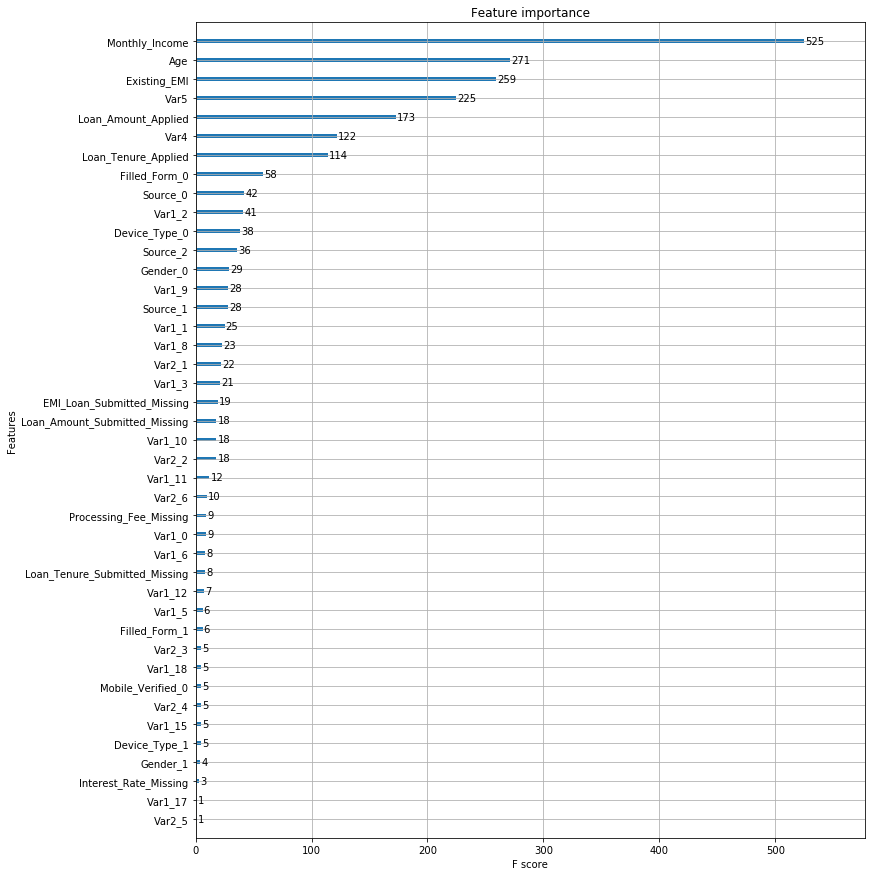

In [66]:
modelfit(xgb1, train, predictors)

In [69]:
n_estimators = xgb1.get_xgb_params()['n_estimators']
n_estimators

118

Step 2: Tune max_depth and min_child_weight
We tune these first as they will have the highest impact on model outcome. To start with, let’s set wider ranges and then we will perform another iteration for smaller ranges.

Important Note: I’ll be doing some heavy-duty grid searched in this section which can take 15-30 mins or even more time to run depending on your system. You can vary the number of values you are testing based on what your system can handle.

In [71]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=n_estimators, gamma=0, 
                                                  subsample=0.8, colsample_bytree=0.8, 
                                                  objective= 'binary:logistic', nthread=4, 
                                                  scale_pos_weight=1, seed=27),
                        param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(train[predictors],train[target])
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.83649, std: 0.00949, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.83613, std: 0.00930, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.83590, std: 0.00979, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.84181, std: 0.00786, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.84164, std: 0.00731, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84091, std: 0.00586, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83836, std: 0.00702, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.83794, std: 0.00687, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83846, std: 0.00599, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.83253, std: 0.00659, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.83297, std: 0.00768, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.83334, std: 0.00584, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 1

Here, we have run 12 combinations with wider intervals between values. The ideal values are 5 for max_depth and 5 for min_child_weight. Lets go one step deeper and look for optimum values. We’ll search for values 1 above and below the optimum values because we took an interval of two.

In [ ]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

## Testing GPU support


In [1]:
import xgboost as xgb
import numpy as np
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
import time

# Fetch dataset using sklearn
cov = fetch_covtype()
X = cov.data
y = cov.target

# Create 0.75/0.25 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, train_size=0.75,
                                                    random_state=42)

# Specify sufficient boosting iterations to reach a minimum
num_round = 10

# Leave most parameters as default
param = {'objective': 'multi:softmax', # Specify multiclass classification
         'num_class': 8, # Number of possible output classes
         'tree_method': 'gpu_hist' # Use GPU accelerated algorithm
         }

# Convert input data from numpy to XGBoost format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

gpu_res = {} # Store accuracy result
print("Starting GPU:")
tmp = time.time()
# Train model
xgb.train(param, dtrain, num_round, evals=[(dtest, 'test')], evals_result=gpu_res)
print("GPU Training Time: %s seconds" % (str(time.time() - tmp)))
print("GPU done!")

# Repeat for CPU algorithm
tmp = time.time()
param['tree_method'] = 'hist'
cpu_res = {}
xgb.train(param, dtrain, num_round, evals=[(dtest, 'test')], evals_result=cpu_res)
print("CPU Training Time: %s seconds" % (str(time.time() - tmp)))
print("CPU Done!")

Starting GPU:
[0]	test-merror:0.254817
[1]	test-merror:0.247733
[2]	test-merror:0.244208
[3]	test-merror:0.240367
[4]	test-merror:0.23888
[5]	test-merror:0.234453
[6]	test-merror:0.232932
[7]	test-merror:0.231252
[8]	test-merror:0.227665
[9]	test-merror:0.226178
GPU Training Time: 84.54550552368164 seconds
GPU done!
[0]	test-merror:0.254831
[1]	test-merror:0.247912
[2]	test-merror:0.244298
[3]	test-merror:0.24069
[4]	test-merror:0.238536
[5]	test-merror:0.234804
[6]	test-merror:0.232229
[7]	test-merror:0.229703
[8]	test-merror:0.227162
[9]	test-merror:0.224519
CPU Training Time: 40.91526460647583 seconds
CPU Done!
